In [1]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from script.plotDisplay import plotDisplay

In [2]:
mlp_model = ctypes.CDLL("modele/mlp/target/release/libmlp_classification.so")

# Définir les types d'arguments et de retour des fonctions C
PROGRESS_CALLBACK = ctypes.CFUNCTYPE(None, ctypes.c_int, ctypes.c_double)
mlp_model.mlpInit.argtypes = [ctypes.POINTER(ctypes.c_size_t), ctypes.c_size_t, ctypes.c_double]
mlp_model.mlpInit.restype = ctypes.c_void_p

mlp_model.mlpTrain.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_bool,
    PROGRESS_CALLBACK,
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.c_char_p  
]
mlp_model.mlpTrain.restype = None


mlp_model.mlpPredict.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.POINTER(ctypes.c_double)
]
mlp_model.mlpPredict.restype = None

mlp_model.mlpFree.argtypes = [ctypes.c_void_p]
mlp_model.mlpFree.restype = None

# First test case

In [3]:
parameter = np.array([2, 1], dtype=np.uintp)
learning_rate = 0.1
epochs = 1000000
checkpoint_interval = 1000
callback_interval = 1000
checkpoint_enable = False
log_enable = False
log_tag = "simpleTestCase".encode('utf-8')

# tensorboard_dir = "./log/"
parameter_ptr = parameter.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, parameter.size, learning_rate)

X_train = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0]
], dtype=np.float64)

y_train = np.array([
    [1.0],
    [-1.0],
    [1.0]
], dtype=np.float64)

print(f'vecteur {X_train}')
print(f'vecteur {X_train.shape}')

vecteur [[0. 0.]
 [0. 1.]
 [1. 0.]]
vecteur (3, 2)
layer : 1
neural matrix : [NeuralMatrix { matrix: [[-0.29734597933560103, -0.05622324061144557]], bias: [0.0], input_size: 2, output_size: 1 }]


In [4]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,  # Nombre total d'époques
    1,
    True,  # is_classification
    callback_func,  # Fonction de callback
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Sample [0. 0.] , predictions = [0.99996559]
Sample [0. 1.] , predictions = [-0.99997625]
Sample [1. 0.] , predictions = [0.99999881]
ndim = 1


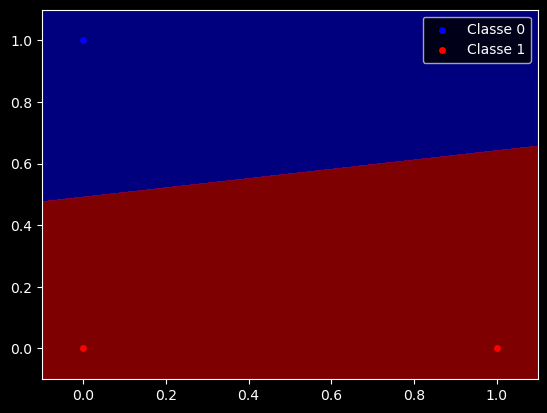

In [5]:
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)


plotDisplay(X_train, y_train, nn, mlp_model)


mlp_model.mlpFree(nn)

# Xor test case

In [65]:
neurons_size = np.array([2, 3, 1], dtype=np.uintp)
learning_rate = 0.01
epochs = 10000000
callback_interval = 10000
checkpoint_enable = False
log_enable = False
log_tag = "xorTestCase".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0]
], dtype=np.float64)

y_train = np.array([
    [-1.0],
    [1.0],
    [1.0],
    [-1.0]
], dtype=np.float64)

layer : 2
neural matrix : [NeuralMatrix { matrix: [[0.384444749088078, -0.7842633184815053], [-0.8816121786720661, -0.5108322417853559], [-0.3534068258666445, -0.026196544149842182]], bias: [0.0, 0.0, 0.0], input_size: 2, output_size: 3 }, NeuralMatrix { matrix: [[-0.404227125447699, -0.30678809188370737, -0.0018187504016982103]], bias: [0.0], input_size: 3, output_size: 1 }]


In [66]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs,
    1,
    True, 
    callback_func,
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/10000000 [00:00<?, ?it/s]

Sample [0. 0.] , predictions = [-0.99579639]
Sample [0. 1.] , predictions = [0.96843968]
Sample [1. 0.] , predictions = [0.96832292]
Sample [1. 1.] , predictions = [-0.94094958]
ndim = 1


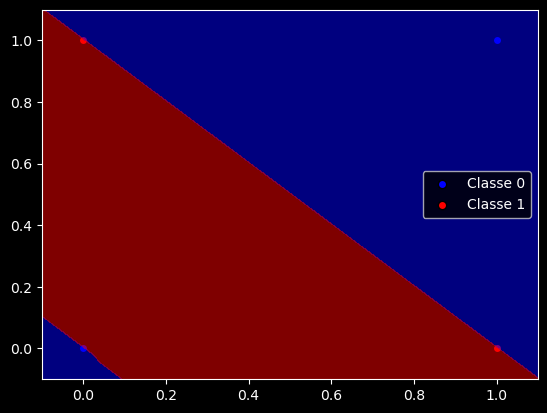

In [67]:
predictions = []
for k in range(len(X_train)):
    prediction = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        prediction.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    predictions.append(prediction.tolist())
    print("Sample", X_train[k], ", predictions =", prediction)


plotDisplay(X_train, y_train, nn, mlp_model)

mlp_model.mlpFree(nn)

# Multi class test

In [68]:
neurons_size = np.array([2, 3], dtype=np.uintp)
learning_rate = 0.001
epochs = 1000000
callback_interval = 1000
checkpoint_enable = False
callback_interval = 1000
log_enable = False
log_tag = "simpleMultiTestCase".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [1.0, 1.0],  # Classe A
    [5.0, 5.0],  # Classe B
    [0, 3.0] 
], dtype=np.float64)

y_train = np.array([
    [1.0, 0.0, 0.0],  # Classe A
    [0.0, 1.0, 0.0],  # Classe B
    [0.0, 0.0, 1.0]   # Classe C
], dtype=np.float64)


layer : 1
neural matrix : [NeuralMatrix { matrix: [[0.7278072592041749, 0.040720558268727114], [-0.6939354948946601, -0.4979619006942064], [-0.2802085725857224, 0.5727564913856051]], bias: [0.0, 0.0, 0.0], input_size: 2, output_size: 3 }]


In [69]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    3,
    epochs,
    16,
    True,  
    callback_func,
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Sample [1. 1.] , predictions = [0.9485613  0.03258781 0.01885088]
Sample [5. 5.] , predictions = [1.92024400e-02 9.80677753e-01 1.19807070e-04]
Sample [0. 3.] , predictions = [0.01597375 0.00595076 0.97807549]
ndim = multi


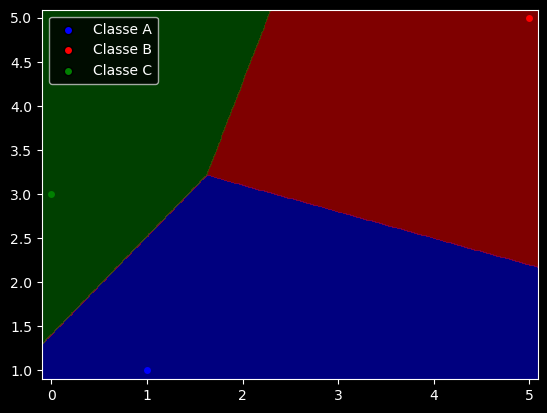

In [70]:
for k in range(len(X_train)):
    predictions = np.zeros(3, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)

plotDisplay(X_train, y_train, nn, mlp_model)

mlp_model.mlpFree(nn)

## Cross entropy

In [149]:

# X_train = np.random.random((1000, 2)) * 2.0 - 1.0
# y_train = np.array([
#     [1, 0, 0] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else 
#     [0, 1, 0] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else 
#     [0, 0, 1] 
#     for p in X_train
# ])

# X_train = np.random.random((500, 2)) * 2.0 - 1.0
# y_train = np.array([[1, 0, 0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else
#               [0, 1, 0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else
#               [0, 0, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else
#               [0, 0, 0]for p in X_train])

# X_train = X_train[[not np.all(arr == [0, 0, 0]) for arr in y_train]]
# y_train = y_train[[not np.all(arr == [0, 0, 0]) for arr in y_train]]

X_train = np.random.random((500, 2)) * 2.0 - 1.0
y_train = np.array([[1.0] if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else [-1.0] for p in X_train])


neurons_size = np.array([2, 4, 1], dtype=np.uintp)
learning_rate = 0.000001
epochs = 1000000
callback_interval = 1000
checkpoint_enable = False
log_enable = False
log_tag = "crossLinearTestCase".encode('utf-8')
parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

# print(X_train)
# print(y_train)


layer : 2
neural matrix : [NeuralMatrix { matrix: [[0.9352879604070883, 0.0025200379224075142], [-0.8724774006068126, -0.6135567199352723], [0.882655641685139, -0.8032142935406044], [-0.07258210478872673, 0.18750880277045257]], bias: [0.0, 0.0, 0.0, 0.0], input_size: 2, output_size: 4 }, NeuralMatrix { matrix: [[0.7008572511202518, -0.6283013137477234, 0.7774071827020399, -0.1910888880530468]], bias: [0.0], input_size: 4, output_size: 1 }]


In [150]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs,
    1,
    True,  
    callback_func,
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

ndim = 1


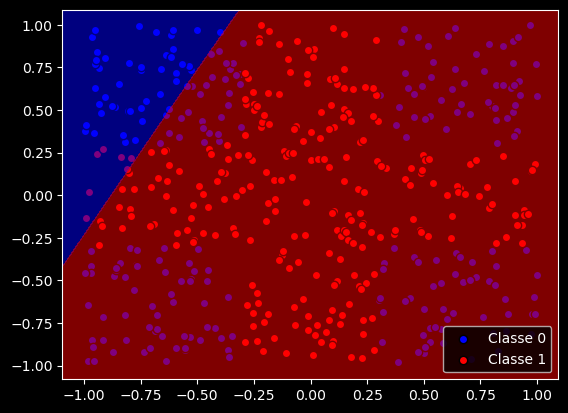

In [151]:
plotDisplay(X_train, y_train, nn, mlp_model)
mlp_model.mlpFree(nn)

# Simple linear test

In [117]:
neurons_size = np.array([1, 1], dtype=np.uintp)
learning_rate = 0.001
epochs = 1000000
callback_interval = 1000
checkpoint_enable = False
callback_interval = 1000
log_enable = False
log_tag = "simpleLinearTestCase".encode('utf-8')
parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [3.0],
    [7.0],
], dtype=np.float64)

y_train = np.array([
    [-3.0],
    [2.0],
], dtype=np.float64)

layer : 1
neural matrix : [NeuralMatrix { matrix: [[0.1105157048162071]], bias: [0.0], input_size: 1, output_size: 1 }]


In [118]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,
    1,
    False,
    callback_func,
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [119]:
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        False,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)

# plotDisplay(X_train, y_train, nn, mlp_model)
mlp_model.mlpFree(nn)

Sample [3.] , predictions = [-3.]
Sample [7.] , predictions = [2.]


# Linear test

In [120]:
neurons_size = np.array([1, 3, 1], dtype=np.uintp)
learning_rate = 0.01
epochs = 10000000
callback_interval = 10000
checkpoint_enable = False
callback_interval = 1000
log_enable = False
log_tag = "linearTestCase".encode('utf-8')
parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [3.0],
    [7.0],
    [9.0],
], dtype=np.float64)

y_train = np.array([
    [8.0],
    [2.0],
    [6.0],
], dtype=np.float64)

layer : 2
neural matrix : [NeuralMatrix { matrix: [[-0.6270270455131652], [0.872076725075718], [0.1302992828835472]], bias: [0.0, 0.0, 0.0], input_size: 1, output_size: 3 }, NeuralMatrix { matrix: [[0.44252050416216404, 0.1575314786204567, 0.19161878519097364]], bias: [0.0], input_size: 3, output_size: 1 }]


In [121]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,
    16,
    False,
    callback_func,
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/10000000 [00:00<?, ?it/s]

In [122]:
allPrediction = []
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        False,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    allPrediction.append(predictions)
    print("Sample", X_train[k], ", predictions =", predictions)

# plotDisplay(X_train, y_train, nn, mlp_model)
mlp_model.mlpFree(nn)

Sample [3.] , predictions = [5.33333333]
Sample [7.] , predictions = [5.33333333]
Sample [9.] , predictions = [5.33333333]


In [ ]:
plt.scatter(X_train, y_train)
plt.scatter(X_train, allPrediction, c='red')
plt.show()